In [2]:
pip install tensorflow

[*********************100%%**********************]  1 of 1 completed
Epoch 1/10
18/18 [==============================] - 15s 345ms/step - loss: 0.0475 - val_loss: 0.0333
Epoch 2/10
18/18 [==============================] - 2s 113ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 3/10
18/18 [==============================] - 1s 61ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 4/10
18/18 [==============================] - 1s 64ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 5/10
18/18 [==============================] - 1s 61ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 6/10
18/18 [==============================] - 1s 61ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 7/10
18/18 [==============================] - 1s 59ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 8/10
18/18 [==============================] - 1s 60ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 9/10
18/18 [==============================] - 1s 65ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 10/10
5/5 [====================

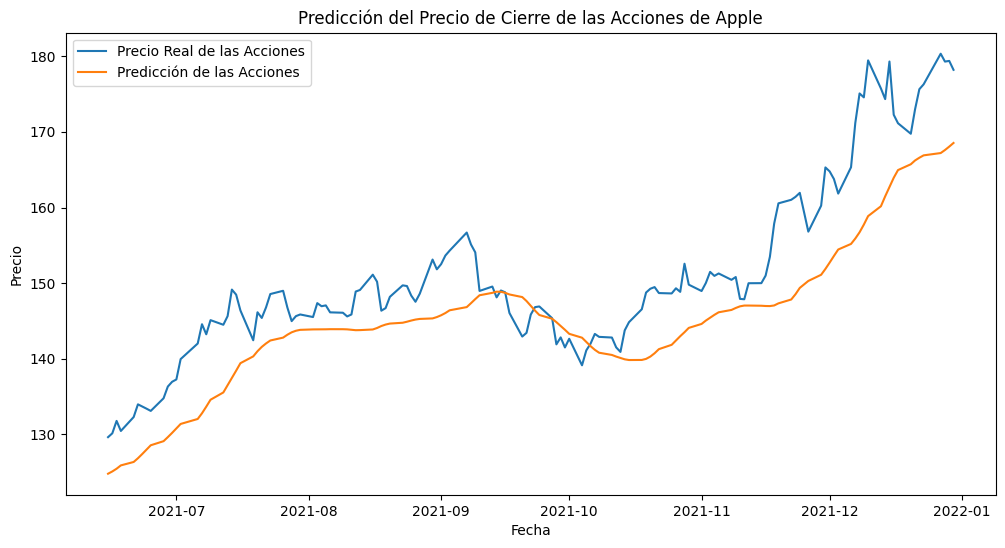

In [3]:
# Importando las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Funciones auxiliares para el ejercicio
def cargar_datos(ticker, inicio, fin):
    """
    Carga los datos históricos de las acciones desde Yahoo Finance.
    """
    import yfinance as yf
    datos = yf.download(ticker, start=inicio, end=fin)
    return datos

def preprocesar_datos(datos, ventana):
    """
    Preprocesa los datos para el modelo LSTM.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    precios_cierre = datos['Close'].values.reshape(-1, 1)
    precios_cierre_escalados = scaler.fit_transform(precios_cierre)

    X, y = [], []
    for i in range(ventana, len(precios_cierre_escalados)):
        X.append(precios_cierre_escalados[i-ventana:i, 0])
        y.append(precios_cierre_escalados[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

def construir_modelo(ventana):
    """
    Construye el modelo LSTM.
    """
    modelo = Sequential()
    modelo.add(LSTM(units=50, return_sequences=True, input_shape=(ventana, 1)))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(units=50, return_sequences=False))
    modelo.add(Dropout(0.2))
    modelo.add(Dense(units=1))
    modelo.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return modelo

# Parámetros
ticker = "AAPL"  # Ejemplo con Apple Inc.
inicio = "2019-01-01"
fin = "2021-12-31"
ventana = 60  # Número de días en la ventana de tiempo para el modelo LSTM

# Cargando y preprocesando los datos
datos = cargar_datos(ticker, inicio, fin)
X, y, scaler = preprocesar_datos(datos, ventana)

# Dividiendo en conjunto de entrenamiento y prueba
tamaño_test = int(len(X) * 0.2)
X_train, X_test = X[:-tamaño_test], X[-tamaño_test:]
y_train, y_test = y[:-tamaño_test], y[-tamaño_test:]

# Construyendo el modelo
modelo = construir_modelo(ventana)

# Entrenando el modelo
historial = modelo.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predicción
predicciones = modelo.predict(X_test)
predicciones = scaler.inverse_transform(predicciones)

# Graficando los resultados
fechas_test = datos.index[-len(y_test):]
plt.figure(figsize=(12, 6))
plt.plot(fechas_test, scaler.inverse_transform(y_test.reshape(-1, 1)), label="Precio Real de las Acciones")
plt.plot(fechas_test, predicciones, label="Predicción de las Acciones")
plt.title("Predicción del Precio de Cierre de las Acciones de Apple")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.show()
